#Vorverarbeitung Loan-Log

Quellen und Packages: 
- Dataset: https://www.win.tue.nl/bpi/doku.php?id=2017:challenge

- Loan-Log wird in Datensatz Präfixen von Instanz-Graphen transformiert
- Event-basierter Ansatz wird angewendet
- Präfix 0: Enthält Datensatz mit ganzen eb Instanz-Graphen

In [ ]:
#torch.__version__

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [ ]:
%%capture
!pip install pm4py

In [ ]:
%load_ext autoreload
%autoreload 2

## Get Data & Dataunderstanding

Data understanding: BPIC 2017: Business process mining – A Loan
process application

In [ ]:
import torch
import pm4py
import numpy as np
from pathlib import Path

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The event log provided this year contains all applications filed in 2016, and their subsequent handling up to February 2nd 2017. In total, there are 1,202,267 events pertaining to 31,509 loan applications. For these applications, a total of 42,995 offers were created. As in 2012, we have three types of events, namely Application state changes, Offer state changes and Workflow events. There are 149 originators in the data, i.e. employees or systems of the company.

For all applications, the following data is available:

- Requested load amount (in Euro),
- The application type,
- The reason the loan was applied for (LoanGoal), and
- An application ID.


For all offers, the following data is available:

- An offer ID,
- The offered amount,
- The initial withdrawal amount,
- The number of payback terms agreed to,
- The monthly costs,
- The creditscore of the customer,
- The employee who created the offer,
- Whether the offer was selected, and
- Whether the offer was accepted by the customer.

## Create Dataset

In [ ]:
# Hauptordner-Pfad
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
# Speicherort des Moduls
%cd /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from tqdm import tqdm
import joblib

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
#%from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from torch_geometric.utils import to_networkx
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
import pm4py
import networkx as nx
import matplotlib.pyplot as plt

class LoanApplicationDataset(InMemoryDataset):
    def __init__(self, root, df, feature, transform=None, pre_transform=None):
        self.df = df
        self.feature = feature
        super(LoanApplicationDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['./loan.dataset']

    def download(self):
        pass
    
    
        
class LoanApplication():
    def __init__(self, feature, label_encoder, normalization, remove_self_loops, rebalancing):
      # End Events:
      self.process_end = ["A_Pending", "A_Denied", "A_Cancelled"]
      # Feature:
      self.feature = feature
      self.label_encoder = label_encoder
      self.normalization = normalization
      self.remove_self_loops = remove_self_loops
      self.rebalancing = rebalancing

    def load_dataset(self, path, log = False):
      # Read Dataset
      # log_o = pm4py.read_xes(path + 'BPI_Challenge_2017_Offer.xes')
      log_a = pm4py.read_xes(str(path / "BPI_Challenge_2017.xes"))

      # Transform to Dataframe
      # pd_o = pm4py.convert_to_dataframe(log_o)
      pd_a = pm4py.convert_to_dataframe(log_a)

      if log == True:
        return log_a, pd_a

      return pd_a

    def preprocess_dataset(self, df):
      # Rename Columns
      df.rename(columns={"concept:name":"Events", "case:concept:name":"ProcessID", "time:timestamp": "Timestamp", "case:LoanGoal": "LoanGoal", "lifecycle:transition": "Transition", "case:RequestedAmount": "Request_Amount", "org:resource": "Resource"}, inplace=True)
      

      # End Events: Sagen aus, ob Credit gewährt wurde oder nicht. Werden aus Process Entfernt und als Label verwedent
      # Siehe Analyse der End Events weiter unten: Löschen der Gruppe mit zwei A_Denied Events 
      # Anzahl der Reihen von Events in einer Gruppe
      g3 = df.groupby(['ProcessID', 'Events']).agg(number_of_rows=('Events', 'count')).reset_index()


      # Prozesse mit mehreren End-Events löschen, falls enthalten
      try:
        # ProcessID der Gruppe erhalten (TODO: Warum process_end[1])
        a = g3[(g3["number_of_rows"] >= 2) & (g3["Events"].isin(self.process_end[1]))]["ProcessID"].values[0]
        # Aus Dataframe löschen
        df = df[df["ProcessID"] != a]
      except: 
        pass 
      
     
      

      # Convertieren von Timestamps zu Integer Timestamps
      df["Timestamp"] = df["Timestamp"].apply(lambda x: int(x.timestamp()))

      # Spalte mit Label der Bewerbungsprozesse (Gruppen) erstellen + Start- und Endknoten hinzzufügen
      df = df.groupby("ProcessID").apply(lambda x: self.add_label_and_duration(x))
      df.reset_index(drop = True, inplace = True) 

      # Datensatz auf W-Events beschränken
      df = df[df["Events"].str.startswith(('W_', "st", "end")) ]

      # Select columns for Modell training
      df = df[self.feature + ["ProcessID", "Timestamp", "Label"]]

      if self.remove_self_loops == True:
        # Datensatz self-loops entfernen
        first_row = df.iloc[0].values    # Erste Reihe speichern, da diese sonst mitentfernt wird
        df["vergleich"] = df[self.feature].ne(df[self.feature].shift().bfill()).astype(int).sum(axis=1)     
        df = df[(df["vergleich"] != 0)]   # Entfernen gleicher aufeinander folgender Reihen 
        df = df.drop(labels = "vergleich", axis=1)
        df.loc[-1] = first_row
        df.index = df.index + 1  # Index anpassen
        df.sort_index(inplace=True) 

      df.fillna(0, inplace = True)

      
      if self.rebalancing == True:
        # Rebalance Dataset: Die Anzahl von Prozess-Instanzen verschiedener Klassen wird durch entfernen von Instanzen angepasst
        df = self.rebalance_dataset(df)
      
      

      # create Pytorch Dataset 
      # dataset = L# oanApplicationDataset(root="../")

      return df

    def prefixes(self, df, lenth): 
      # Instanzen werden auf die definierte länge verkürzt  
      df_group  = df.groupby("ProcessID").apply(lambda x: self.build_prefix(x, lenth))
      df_group.reset_index(drop=True, inplace=True)
      # Start und End-Knoten hinzufügen
      # df_group = df_group.groupby("ProcessID").apply(lambda x: self.add_nodes(x))
      # df_group.reset_index(drop=True, inplace=True)
      return df_group 

    def build_prefix(self, df, lenth):
      if lenth < len(df):
        return df.iloc[:lenth]
      else:
        return None

    def preprocess_dataset_analysis(self, df):
      # Rename Columns
      # df.rename(columns={"concept:name":"Events", "case:concept:name":"ProcessID", "time:timestamp": "Timestamp", "case:LoanGoal": "LoanGoal" }, inplace=True)

      # Select columns for Modell training
      # df = df[self.feature + ["ProcessID", "Timestamp"]]

      # End Events: Sagen aus, ob Credit gewährt wurde oder nicht. Werden aus Process Entfernt und als Label verwedent
      # Siehe Analyse der End Events weiter unten: Löschen der Gruppe mit zwei A_Denied Events 
      # Anzahl der Reihen von Events in einer Gruppe
      g3 = df.groupby(['case:concept:name', 'concept:name']).agg(number_of_rows=('concept:name', 'count')).reset_index()

      # Prozesse mit mehreren End-Events löschen, falls enthalten
      try:
        # ProcessID der Gruppe erhalten (TODO: Warum process_end[1])
        a = g3[(g3["number_of_rows"] >= 2) & (g3["concept:name"].isin(self.process_end[1]))]["case:concept:name"].values[0]
        # Aus Dataframe löschen
        df = df[df["case:concept:name"] != a]
      except: 
        pass 

      # Convertieren von Timestamps zu Integer Timestamps
      # df["Timestamp"] = df["Timestamp"].apply(lambda x: int(round(x.timestamp())))

      # Spalte mit Label der Bewerbungsprozesse (Gruppen) erstellen + Start- und Endknoten hinzzufügen
      # df = df.groupby("ProcessID").apply(lambda x: self.add_label_and_nodes(x))
      # df.reset_index(drop = True, inplace = True) 

      # Datensatz auf W-Events beschränken
      df = df[df["concept:name"].str.startswith(('W_', "st", "end")) ]

      # Datensatz self-loops entfernen
      first_row = df_test.iloc[0].values    # Erste Reihe speichern, da diese sonst mitentfernt wird
      df["vergleich"] = df[['Events', "Action"]].ne(df[['Events',"Action"]].shift().bfill()).astype(int).sum(axis=1)  # Entfernen gleicher aufeinander folgender Reihen     
      df.iloc[0] = np.append(first_row, [0])  # anfügen der ersten Reihe
      df.drop(labels = "vergleich", axis=1, inplace = True) # Entfernen der Hilfsspalte
      
      # Rebalance Dataset: Die Anzahl von Prozess-Instanzen verschiedener Klassen wird durch entfernen von Instanzen angepasst
      # df = self.rebalance_dataset(df)
      
      

      # create Pytorch Dataset 
      # dataset = L# oanApplicationDataset(root="../")

      return df

    def encode_data(self, df):
      # Split in X und y 
      X = df.drop("Label", axis =1)
      y = df["Label"]
      
      # Spalten, welche Encoded werden sollen
      col_trans = self.feature + ["ProcessID"]
      #print(col_trans)
      
      if self.label_encoder == True:
        X_encoded, encoder = self.label_encoding(X, col_trans)
      else:
        # Encoding
        X_encoded, encoder = self.one_hot_encoding(X, col_trans)
        
      return X_encoded,y, encoder

    def one_hot_encoding(self, X, col_trans):
      oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)
      o_encoder = OrdinalEncoder()

      # Nominale Variablen
      nominal_cols_definition = ["Events", "Action", "Transition", "LoanGoal", "Resource", "Accepted", "Selected"]
      # Ordinale Variablen
      #ordinal_cols_definition = ["ProcessID"]  #
      normalize_cols =  ["Request_Amount", "Time_Bevor_Event"]

      # Feature Array in nominal_col und ordinal_col aufsplitten
      nominal_col = [x for x in col_trans if x in nominal_cols_definition ]
      #ordinal_col = [x for x in col_trans if x in ordinal_cols_definition ]

      # if len(ordinal_col) != 0:   # Testen ob Liste leer ist
      #   # Encoding Ordinale Spalten
      #   X[ordinal_col] = pd.DataFrame(o_encoder.fit_transform(X[ordinal_col]))

      if len(nominal_col) != 0:
        #[:print(X[nominal_col[:].columns)
        # One Hot Encoding anwenden
        t = pd.DataFrame(oh_encoder.fit_transform(X[nominal_col]))

        # Index reparieren
        t.index = X.index
       

        # Rename Columns
        t.columns = oh_encoder.get_feature_names(nominal_col[:])

        # Nominale Spalten entfernen und mit den Encoded Spalten ersetzen
        X.drop(nominal_col[:], axis = 1, inplace= True)

        # Zusammenführen der Dataframes
        X_encoded = pd.concat([X, t], axis=1)

        # Normalisieren nummerischer Spalten
        df_feature = pd.DataFrame(X_encoded[normalize_cols])
        scaler = MinMaxScaler()
        df_feature = pd.DataFrame(scaler.fit_transform(df_feature), 
                                          columns=df_feature.columns, index=df_feature.index)
        #print(df_feature.columns)
        X_encoded[normalize_cols] = df_feature

      
      return X_encoded, [oh_encoder, o_encoder]

    def label_encoding(self, X, col_trans):
      # Initialisierung der Label Encoder
      d = defaultdict(LabelEncoder)

      # Encoding the variable
      X[col_trans] = X[col_trans].apply(lambda x: d[x.name].fit_transform(x))
      return X, [d]

    def rebalance_dataset(self, df):
      n_unique = df.groupby("Label")["ProcessID"].nunique()   # Zahl der Klassen
      keep = n_unique[1]    # Klasse 0 > Klasse 1 -> Klasse 0 wird auf Zahl der Klasse 1 verkleinert
      df0_keep = df[df["Label"] == 0] # Instanzen aus Klasse 0
      df1_keep = df[df["Label"] == 1] 
      df0_keep = df0_keep[df0_keep['ProcessID'].isin(df0_keep["ProcessID"].unique()[:keep])]  # Länge Klasse 0 = Länge Klasse 1
      df = pd.concat([df0_keep, df1_keep],axis=0) # Zusammenfügen der beiden klassen
      df.reset_index(drop = True, inplace = True ) # Index reparieren
      return df


         

 
          


    def add_nodes(self, g):
      g.reset_index(drop=True, inplace = True)
      # ts_0 = g.iloc[0]["timestamp"]
      # ts_1 = g.iloc[-1]["timestamp"]
      # review_id = g.iloc[0]["review_id"]
      
      # Start-Knoten Reihe erstellen
      first_row = g.iloc[0] # kopieren der ersten Reihe
      first_row["Events"] = "start"
      first_row["Action"] = "0"
      first_row["Timestamp"] = first_row["Timestamp"] - 1

      # End-Knoten Reihe erstellen
      last_row = g.iloc[-1] # kopieren der letzten Reihe
      last_row["Events"] = "end"
      last_row["Action"] = "0"
      last_row["Timestamp"] = last_row["Timestamp"] + 1

      
      g.loc[-1] = list(first_row) # Start-Knoten hinzufügen
      g.loc[len(g.index)] = list(last_row) # End-Knoten hinzufügen
      g.index = g.index + 1  # Index anpassen
      g.sort_index(inplace=True) 
      return g

    # Methode um jeder Gruppe das passende Label zu zuordnen
    def add_label_and_duration(self, group): 
      
      if self.process_end[0] in group.Events.values:  # Loan vergeben
        group["Label"] = 1    # Neue Spalte mit Label des Prozesses
        group = group[group.Events != self.process_end[0]] # entfernen des Events aus dem Log
        #group = self.add_nodes(group) # Start- und Endknoten anfügen
        group["Time_Bevor_Event"] = group["Timestamp"].diff().fillna(0)
        return group
      elif self.process_end[1] in group.Events.values:  # Loan abgelehnt
        group["Label"] = 0
        group = group[group.Events != self.process_end[1]]
        #group = self.add_nodes(group)
        group["Time_Bevor_Event"] = group["Timestamp"].diff().fillna(0)
        return group
      elif self.process_end[2] in group.Events.values:
        group["Label"] = 0     # Stop Event 1 und 2 werden in die selbe Klasse zusammengefasst. Modell soll Vorhersagen ob ein Loan vergeben wird oder nicht (Binär)
        group = group[group.Events != self.process_end[2]]
        #group = self.add_nodes(group)
        group["Time_Bevor_Event"] = group["Timestamp"].diff().fillna(0)
        return group


    def process(self, feature, df, device):
        
        data_list = []

        # process by session_id
        grouped = df.groupby('ProcessID')

        # Define group to be explained in the TestSet
        # X_test = df_log_a[df_log_a["ProcessID"]==8]
        
        for ProcessID, group in tqdm(grouped):           
            # Sortieren nach Timestamp, sodass sich die Events in richtiger zeitlicher Reihenfolge befinden
            # group = group.sort_values("Timestamp")
                      
            # Eindeutige Ids für Events vergeben. Dient der Vorbereitung auf das Bestimmen von Knoten
            #ids =  pd.factorize(group[feature].apply(tuple, axis=1))[0] 
            #group["NodeId"] = ids
            #self.node_ids.append(ids)   
                        
            
            # Knoten aus den One-Hot-Encodeden Featuren bestimmen. node_feature speichert alle möglichen Knoten 
            node_features = group[feature].to_numpy() #entfernen der nodeId
            #node_features = group.loc[group.ProcessID==ProcessID,["NodeId"]+ feature].sort_values('NodeId').drop_duplicates(subset=["NodeId"]).drop(columns = ["NodeId"]).values
            # node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').drop_duplicates(subset = ["sess_item_id"]).values 
            
            #node_features zu Tensor transformieren
            node_features = torch.from_numpy(node_features).float().to(device) #.unsqueeze(1)
            
            # Ziel- und Quellknoten bestimmen. 
            # Eine direktionale Kante wird zwischen zwei aufeinander folgenden Knoten von i nach j platziert, wen gilt: i <= j 
            group["NodeId"] = list(range(0,group.shape[0]))
            target_nodes = group.NodeId.values[1:]
            source_nodes = group.NodeId.values[:-1]
            x = node_features            
            
            # 2 Dim Tensor zur Kantenbestimmung erstellen
            edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)            
            
            # Label der Prozess-Instanz 
            y = torch.cuda.FloatTensor([group.Label.values[0]])            

            # Graph-Instanz als Data-Objekt 
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        #data, slices = self.collate(data_list)
        return(data_list)
        




## Exemplarisches Durchführen des Preprocessings

In [ ]:
# Variablen 
feature = ["Events", "Action", "LoanGoal", "Transition", "Request_Amount", "Resource", "Time_Bevor_Event"]   
normalization = False
label_encoder = False
remove_self_loops = False
rebalancing = False
# initialisierung der LoanApplication Klasse
loan_application = LoanApplication(feature, label_encoder, normalization, remove_self_loops, rebalancing)

In [ ]:
# Laden des Datensatzes 
log, df = loan_application.load_dataset(path / "datasets/Review_Log", log = True)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [ ]:
# Sicherheitscopy 
# für Preprocessing
df1 = df.copy()
# für Analyse des Datensatzes
#df2 = df.copy

In [ ]:
df1.shape[0]

766122

In [ ]:
# Daten Bereinigung
df1 = loan_application.preprocess_dataset(df1)

In [ ]:
df2 = df1.copy()

In [ ]:
# Bilden von Präfixen
# die verschiedenen Präfixe werden in einem dict der Größe nach sortiert gespeichert.
# Längen von Präfixen: 4,7,10,13,16,19
df_dict = {}
for length in range(4,20, 3): 
  new_df = loan_application.prefixes(df2, length)
  df_dict[length] = new_df
# Gesamter Datensatz
df_dict[0] = df2

In [ ]:
g = df_dict[4].groupby("ProcessID")

In [ ]:
a = next(iter(g))[1]

In [ ]:
a["test"] = list(range(0,a.shape[0]))
a

,Events,Action,LoanGoal,Transition,Request_Amount,Resource,Time_Bevor_Event,ProcessID,Timestamp,Label,test
0,W_Handle leads,Created,"Other, see explanation",schedule,5000.0,User_1,0.0,Application_1000086665,1470239841,0,0
1,W_Handle leads,Deleted,"Other, see explanation",withdraw,5000.0,User_1,67.0,Application_1000086665,1470239908,0,1
2,W_Complete application,Created,"Other, see explanation",schedule,5000.0,User_1,0.0,Application_1000086665,1470239908,0,2
3,W_Complete application,Obtained,"Other, see explanation",start,5000.0,User_14,78061.0,Application_1000086665,1470317969,0,3


In [ ]:
df_dict2 = df_dict.copy()

In [ ]:
# Encoding der X-Feaute durchführen
encoder_dict = {}
for length in df_dict2:   
  print('Länge des Präfixes: ',length)
  df_encode = df_dict2[length]
  
  X, y, encoder = loan_application.encode_data(df_encode)
  # X und y zu einem Dataframe zusammenführen für das erstellen des Datensets
  df3 = pd.concat([X,y], axis = 1)
  df_dict2[length] = df3
  encoder_dict[length] = encoder

Länge des Präfixes:  4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Länge des Präfixes:  7


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Länge des Präfixes:  10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Länge des Präfixes:  13


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Länge des Präfixes:  16


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Länge des Präfixes:  19


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Länge des Präfixes:  0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Liste der Knoten-Feature in X + Prozess-ID
feature_encoded_dict = {}
for length in df_dict2:  
  df_f = df_dict2[length] 
  feature_encoded = list(df_f.loc[ : ,~df_f.columns.isin(["ProcessID", "Timestamp", "Label"])].columns)
  feature_encoded_dict[length] = feature_encoded

In [ ]:
a[["Request_Amount",	"Time_Bevor_Event",	"ProcessID"]].values.tolist()

[[0.027777777777777776, 5.468233935422344e-07, 'Application_1000158214'],
 [0.027777777777777776, 3.7730814154414174e-05, 'Application_1000158214'],
 [0.027777777777777776, 0.0, 'Application_1000158214'],
 [0.027777777777777776, 0.18460757765985836, 'Application_1000158214'],
 [0.09999999999999999, 0.0, 'Application_1000311556']]

In [ ]:
# Datensätze erstellen
dataset_dict2 = {}
for length in df_dict2:  
  #dataset = CreateDatasetReview(root=process_path, df = df_dict2[length], feature = feature_encoded_dict[length], device = device) 
  datalist = df_dict2[length]
  dataset2 = loan_application.process(feature_encoded_dict[length],datalist , device)
  dataset_dict2[length] = dataset2

100%|██████████| 31411/31411 [00:40<00:00, 770.64it/s]


### Visualisierung

In [ ]:
id_vis = 10
data = dataset_dict2[id_vis][1]
data

Data(edge_index=[2, 9], x=[10, 179], y=[1])

In [ ]:
norm_cols = ['Request_Amount', 'Time_Bevor_Event']
node_feature = feature_encoded_dict[id_vis][len(norm_cols):]
#node_feature

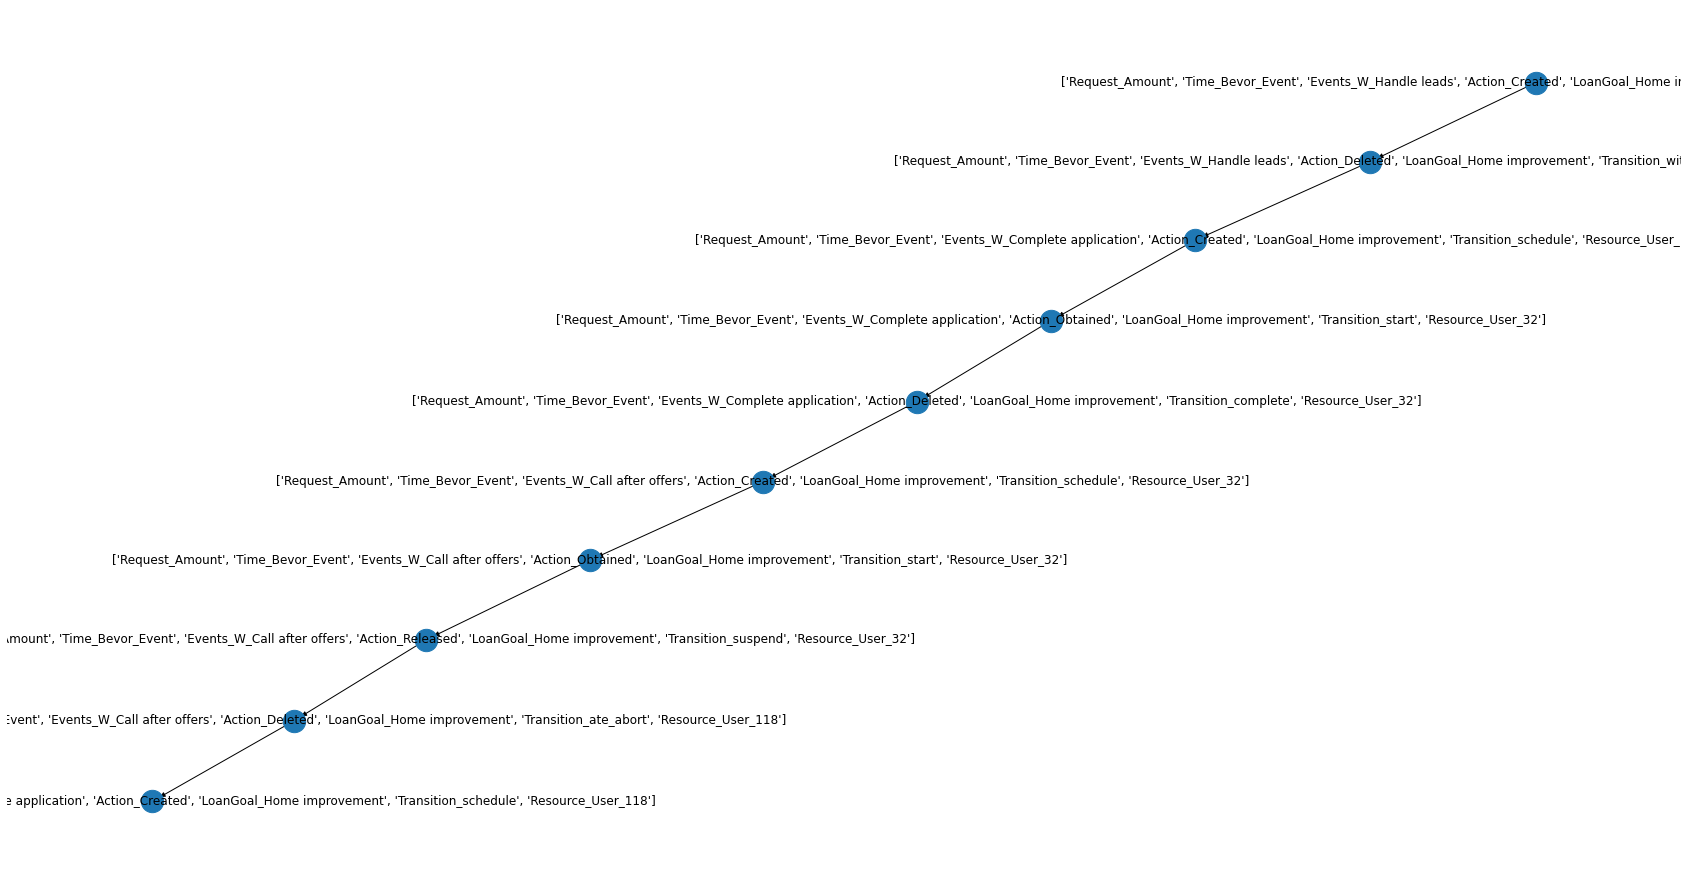

In [ ]:

''' Visualisierung einer Graphen-Instanz mit Knoten-Featurn'''
# self.data = data
# dic_encoder = self.dic_encoder 
# scaler = self.scaler 

# Netzwerkx Objekt erstellen
G = to_networkx(data)

# Array aller Knoten erstellen
if data.num_features > 1:
    nodes = data.x.squeeze(1).tolist()
else:
    nodes = data.x.tolist()

# Normalisierung Rückgängig machen und Node-Werte von float zu int transformieren
# if scaler != None:
#     nodes = scaler.inverse_transform(nodes)
#     nodes = np.around(np.array(nodes))
# else:
#   nodes = [int(x) for x in nodes]                                        

# Encoder 
# encoder_name = d['event_name']
# encoder_transition = d["transition"]
# encoder_result = d["result"]
# encoder_timestamp = d["timestamp"]

# Encoding Rückgängig machen
codes = []
# Label-Encoding

# One-Hot-Encoder, Namen durch Multiplikation mit Feature-Vector erhalten
n_labels = get_labels_ohe(nodes, node_feature)

# Wenn kein Encoder übergeben wurde, werden die Nummern zur graphischen Darstellung verwendet            
# n_labels = {}
# for n_id, node in enumerate(nodes):
#     n_labels[n_id] = node


# Darstellen des Netzwerks
pos = nx.kamada_kawai_layout(G)  
fig = plt.figure(figsize=(30, 16))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, arrows = True )
nx.draw_networkx_labels(G,pos, labels=n_labels)
plt.show()



In [ ]:
def get_labels_ohe(nodes, node_features):   
      
        n_labels = {}
        for n_id, node in enumerate(nodes):
            # Float zu Int transformieren
            node = list(map(int, node))
            node = node[len(norm_cols):]
            # Erhalten der Benennungen durch Multiplizieren der node_feature-Liste mit der Encoded node-Liste. 
            # Durch OHE ist Wert eines Features [1,0]. Ergebnis ist eine Liste aller Feature. Output: {node_id: [feature]}
            n_labels[n_id] = norm_cols + sum([[s] * n for s, n in zip(node_features, node)], [])
        return  n_labels

### Datensatz speichern

Speicherformat: **datensatz_name_startknoten_featureanzahl_encoding**

In [ ]:
dataset_name = "loan_all_events_fall_ohe_wEvents_5_2" 

In [ ]:
feature

['Events_W_Assess potential fraud',
 'Events_W_Call after offers',
 'Events_W_Call incomplete files',
 'Events_W_Complete application',
 'Events_W_Handle leads',
 'Events_W_Personal Loan collection',
 'Events_W_Shortened completion ',
 'Events_W_Validate application',
 'Events_end',
 'Events_start',
 'Action_0',
 'Action_Created',
 'Action_Deleted',
 'Action_Obtained',
 'Action_Released']

In [ ]:

# Datensatz speichern
torch.save(dataset_dict2, path / str("datasets/dataset_" + dataset_name) )
# Labelencoder speicher 
#joblib.dump(encoder , "datasets/encoder_" + dataset_name + ".joblib")
# OneHotEncoder speichern. In Diesem Fall wird nur die Liste der Feature namen gespeichert
joblib.dump(feature_encoded_dict, "datasets/encoder_" + dataset_name + ".joblib")